In [5]:
#| default_exp conformal

In [6]:
#| export

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import wrapping as tcwrap
from blender_tissue_cartography import rotation as tcrot

import numpy as np
from copy import deepcopy
import warnings
import igl

from scipy import interpolate, ndimage, optimize, sparse, spatial
from skimage import registration, transform

import matplotlib as mpl

import skfmm

In [7]:
from tqdm.notebook import tqdm
from importlib import reload

import matplotlib.pyplot as plt
from scipy import stats

In [8]:
np.set_printoptions(suppress=True)

## To Do:

- use rotation registration code from notebook 03c for aligning maps to the sphere.
- use interpolation to transfer vertex coordinates from mesh A to mesh B given sphere maps
- package into nice functions
- set UV maps to sphere, disk, as UV attributes of mesh. add option to save different UV coordinates for `tcio.ObjMesh`

## Conformal wrapping

In this notebook we present some additional wrapping algorithms. So far, we have wrapped two meshes by simply projection each source mesh vertex onto the closest position on the target mesh, and carrying out some on-surface smoothing. This works, but is not necessarily extremely robust, and can lead to very deformed UV maps when there are large, localized deformations.

Here, we'll implement an alternative algorithm which works by (a) mapping each mesh into a common reference in a mathematically standartized way and then (b) chaining together the map from the source mesh to the common reference and from the reference to the target mesh to get a surface-surface map.

We provide algorithms for meshes of disk and of spherical topology (potentially with holes). For arbitrary genus (i.e. handles, like a torus), one can take a look at hyperbolic orbifolds https://github.com/noamaig/hyperbolic_orbifolds/. Not implemented here.

#### Loading test data

Let's load the test meshes from the fly midgut

In [9]:
mesh_initial_UV = tcio.ObjMesh.read_obj("movie_example/initial_uv.obj")
mesh_final_UV = tcio.ObjMesh.read_obj("movie_example/final_uv.obj") # this is a UV map defined for tpt 20

In [10]:
mesh_60 = tcio.read_other_formats_without_uv(f"movie_example/meshes/mesh_{str(60).zfill(2)}.ply")

## Disk

Following https://libigl.github.io/libigl-python-bindings/tut-chapter4/. We first map each mesh to the unit disk using harmonic coordinates. Boundary conditions are such that the boundary loop is mapped to the unit circle isometrically (i.e. relative distances are preserved).

There is still a remaining rotation degree of freedom. This is fixed by optimizing the match of the conformal factors (i.e. the area distortion of the maps to the disk) using phase correlation.

In [11]:
#| export

def map_to_disk(mesh):
    """
    Map mesh to unit disk by computing harmonic UV coordinates.
    
    The longest boundary loop of the mesh is mapped to the unit circle.
    Follows https://libigl.github.io/libigl-python-bindings/tut-chapter4/.
    
    The disk rotation angle is arbitrary
    
    Parameters
    ----------
    mesh : tcio.ObjMesh
        Mesh. Must be topologically a disk (potentially with holes),
        and should be triangular.
    quantiles : tuple
        Image quantile to set to 0 and 1.
    
    Returns
    -------
    mesh_parametrized : tcio.ObjMesh
        Mesh with UV coordinates mapping it to the disk.
    
    """
    if not mesh.is_triangular:
        warnings.warn("Warning: ignoring non-triangular faces", RuntimeWarning)
    ## Find the open boundary
    bnd = igl.boundary_loop(mesh.tris)
    assert len(bnd) > 0, "No boundary found! Your mesh may not be a disk" 

    ## Map the boundary to a circle, preserving edge proportions
    bnd_uv = igl.map_vertices_to_circle(mesh.vertices, bnd)

    ## Harmonic parametrization for the internal vertices
    uv = igl.harmonic(mesh.vertices, mesh.tris, bnd, bnd_uv, 1)
    uv = uv/2+np.array([0.5, 0.5])
    
    ## create new mesh
    mesh_parametrized = tcio.ObjMesh(vertices=mesh.vertices, texture_vertices=uv, normals=None,
                                faces=[[[v,v] for v in fc] for fc in mesh.tris])
    mesh_parametrized.set_normals()
    
    return mesh_parametrized

In [12]:
mesh = tcio.ObjMesh.read_obj("movie_example/plane_example.obj")

mesh_parametrized = map_to_disk(mesh)

(-0.049841709467476805,
 1.049992462355594,
 -0.04994346724076043,
 1.0496419841918154)

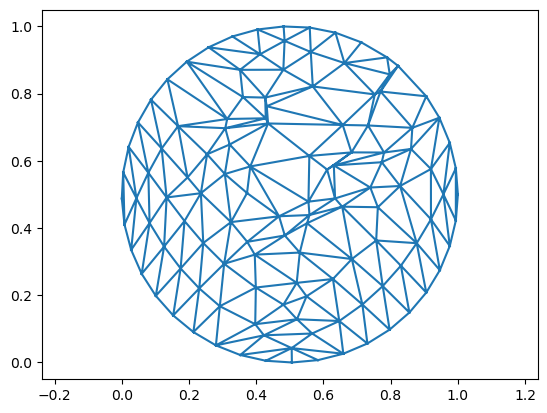

In [13]:
plt.triplot(*mesh_parametrized.texture_vertices.T, mesh_parametrized.texture_tris)
plt.axis("equal")

In [14]:
igl.flipped_triangles(mesh_parametrized.texture_vertices, mesh_parametrized.texture_tris)

array([], shape=(0, 0), dtype=int64)

#### Rotational alignment

The disk can still be rotated freely. I think the "centering" part of Moebius alignment is already done automatically? Use method from Moebius registration paper:

"We next seek the rotation that best aligns the two parameterizations. To do so, we first sample the conformal factors of each mesh onto a regular spherical grid (Figure 6, top right). We then find the rotation that maximizes the correlation between conformal factors, via a fast spectral transform."

In [113]:
#| export

def rot_mat(phi):
    """Get rotation matrix with angle phi"""
    return np.array([[np.cos(phi), np.sin(phi)],[-np.sin(phi), np.cos(phi)]])

In [129]:
mesh_a = deepcopy(mesh_parametrized)
mesh_b = deepcopy(mesh_parametrized)

phi = -0.01*np.pi
mesh_b.texture_vertices = ((mesh_a.texture_vertices-np.array([0.5, 0.5]))@rot_mat(phi)+np.array([0.5, 0.5])
                           +np.array([0.02, 0.]))

(-0.05082937347662009,
 1.070733406547603,
 -0.04996005874720119,
 1.0499904058270713)

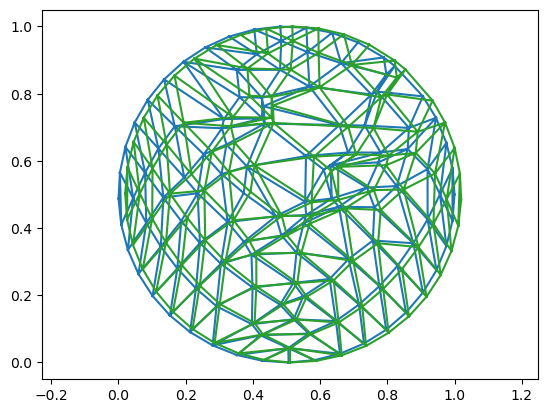

In [130]:
plt.triplot(*mesh_a.texture_vertices.T, mesh_a.texture_tris)

plt.triplot(*mesh_b.texture_vertices.T, mesh_b.texture_tris)
plt.axis("equal")

In [187]:
# find closest points and triangles on target mesh
source_points = np.pad(mesh_a.texture_vertices, ((0,0), (0,1))) 
target_points = np.pad(mesh_b.texture_vertices, ((0,0), (0,1))) 
target_tris = mesh_b.texture_tris

distances, indices, points = igl.point_mesh_squared_distance(source_points, target_points, target_tris)
hit_tris = target_tris[indices]
# barycentric coordinates of the hit points. need small hack for data type issue 
barycentric = igl.barycentric_coordinates_tri(np.array(points, order="C"),
                                             *np.array(target_points[hit_tris].transpose((1,0,2)), order='C'))
# using the barycentric coords we can now interpolate
interpolated = np.einsum('vt,vt...->v...', barycentric, target_points[hit_tris])
# this gives us the same result as going for the closest point directly,
# but now we can also interpolate _other_ attributes
#np.allclose(interpolated, points)

In [188]:
interpolated.shape

(121, 3)

In [189]:
barycentric.shape, target_points[hit_tris].shape

((121, 3), (121, 3, 3))

In [190]:
#| export

def transfer_per_verte_attribute(source_vertices, target_vertices, target_faces, attribute):
    """
    Transfer a per-vertex attribute from one mesh to another via barycentric interpolation.
    
    For each point among the source vertices, find the closest point on the target mesh
    (not necessarily a target vertex!), and find the value of the per-target-vertex
    attribute "attribute" via barycentric interpolation.
    
    This can be used to copy e.g. 3d coordinates from one mesh to another given 
    a common paramatrization (e.g. to disk or sphere)/
    
    Parameters
    ----------
    source_vertices : np.array
        Vertices onto which to transfer the attribute
    target_vertices : np.array
        Vertices on which the attribute is defined
    target_faces : np.arraay
        Triangular faces of target mesh, indices into the target_vertices array
    attribute : np.array
        Must have same length of axis 0 as target_vertices
        
    Returns
    -------
    transfered_attribute : np.array
        Same length of axis 0 as source_vertices.
    
    """
    distances, indices, points = igl.point_mesh_squared_distance(source_points, target_points, target_tris)
    hit_tris = target_tris[indices]
    # barycentric coordinates of the hit points. need small hack for data type issue 
    barycentric = igl.barycentric_coordinates_tri(np.array(points, order="C"),
                                                 *np.array(target_points[hit_tris].transpose((1,0,2)), order='C'))
    interpolated = np.einsum('vt,vt...->v...', barycentric, attribute[hit_tris])
    return interpolated

In [191]:
source_points = np.pad(mesh_a.texture_vertices, ((0,0), (0,1))) 
target_points = np.pad(mesh_b.texture_vertices, ((0,0), (0,1))) 
target_tris = mesh_b.texture_tris

interpolated = transfer_per_verte_attribute(source_points, target_points, target_tris, target_points[:,:2])

(-0.02997531445631003,
 1.0697403561180645,
 -0.049903497069471885,
 1.0499877124138461)

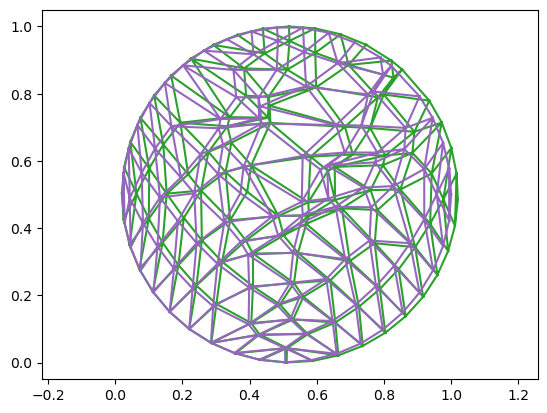

In [192]:
#plt.triplot(*mesh_a.texture_vertices.T, mesh_a.texture_tris, c="tab:blue")

plt.triplot(*mesh_b.texture_vertices.T, mesh_b.texture_tris, c="tab:green")

plt.triplot(*interpolated.T, mesh_b.texture_tris, c="tab:purple")

plt.axis("equal")

array([[1.        , 0.5       , 0.        ],
       [0.99393984, 0.57761081, 0.        ],
       [0.97590625, 0.65334028, 0.        ],
       [0.94486924, 0.72823531, 0.        ],
       [0.90590789, 0.79195682, 0.        ],
       [0.8221015 , 0.88242728, 0.        ],
       [0.78938189, 0.90774762, 0.        ],
       [0.71268967, 0.95250757, 0.        ],
       [0.63571005, 0.98123049, 0.        ],
       [0.55936782, 0.99646295, 0.        ],
       [0.48180639, 0.99702837, 0.        ],
       [0.99393984, 0.42238919, 0.        ],
       [0.95692602, 0.50035668, 0.        ],
       [0.91978229, 0.57564767, 0.        ],
       [0.86055974, 0.63522619, 0.        ],
       [0.86443279, 0.69812988, 0.        ],
       [0.76988294, 0.80624446, 0.        ],
       [0.79728261, 0.85715729, 0.        ],
       [0.66250426, 0.89082602, 0.        ],
       [0.56237183, 0.92363657, 0.        ],
       [0.48442372, 0.95694299, 0.        ],
       [0.40560553, 0.98519422, 0.        ],
       [0.

In [18]:
#| export

def rotational_align_disk(mesh_source, mesh_target, q=0.05, n_grid=256):
    """
    Rotationally align two UV map to the disk by the conformal factor.
    
    Computes aligned UV coordinates. Assumes that the UV
    coordinates are in [0,1]^2. Rotational alignment works by computing
    the conformal factor (how much triangle size changes as it is
    mapped to the plane), which is rotated so that the maximum is at the y-axis
    via a Fourier transform.
    
    Parameters
    ----------
    mesh_source : tcio.ObjMesh
        Mesh. Must be topologically a disk (potentially with holes),
        and should be triangular.
    mesh_target : tcio.ObjMesh
        Mesh. Must be topologically a disk (potentially with holes),
        and should be triangular.
    q : float between 0 and 0.5
        Conformal factors are clipped at this quantile to avoid outliers.
    n_grid : int
        Grid for interpolation of conformal factor during alignment
    
    Returns
    -------
    new_texture_vertices_mesh_source : np.array
        Rotationally aligned texture vertices
    
    """
    assert mesh_source.tris.shape==mesh_source.texture_tris.shape,\
        "3d and UV triangulations must be identical"
    assert (mesh_source.tris==mesh_source.texture_tris).all(),\
        "3d and UV triangulations must be identical"
    assert mesh_target.tris.shape==mesh_target.texture_tris.shape,\
        "3d and UV triangulations must be identical"
    assert (mesh_target.tris==mesh_target.texture_tris).all(),\
        "3d and UV triangulations must be identical"
    # compute conformal distortion factors, clip to avoid outliers
    conformal_factor_source = (igl.doublearea(mesh_source.vertices, mesh_source.tris)/
                               igl.doublearea(mesh_source.texture_vertices, mesh_source.texture_tris))
    conformal_factor_source = np.clip(conformal_factor_source, np.quantile(conformal_factor_source, q),
                                      np.quantile(conformal_factor_source, 1-q))
    uv_centroids_source = mesh_source.texture_vertices[mesh_source.texture_tris].mean(axis=1)
    conformal_factor_target = (igl.doublearea(mesh_target.vertices, mesh_target.tris)/
                               igl.doublearea(mesh_target.texture_vertices, mesh_target.texture_tris))
    conformal_factor_target = np.clip(conformal_factor_target, np.quantile(conformal_factor_target, q),
                                      np.quantile(conformal_factor_target, 1-q))
    uv_centroids_target = mesh_target.texture_vertices[mesh_target.texture_tris].mean(axis=1)
    # interpolate onto a grid
    U, V = np.meshgrid(*2*[np.linspace(0, 1, n_grid)])
    conformal_factor_source = igl.average_onto_vertices(mesh_source.vertices, mesh_source.texture_tris,
                                                        np.stack(3*[conformal_factor_source], axis=-1))[:,0]
    conformal_factor_target = igl.average_onto_vertices(mesh_target.vertices, mesh_target.texture_tris,
                                                        np.stack(3*[conformal_factor_target], axis=-1))[:,0]
    interpolated_source = mpl.tri.LinearTriInterpolator(mpl.tri.Triangulation(*mesh_source.texture_vertices.T,
                                                                              mesh_source.texture_tris),
                                                        conformal_factor_source)(U,V)
    interpolated_target = mpl.tri.LinearTriInterpolator(mpl.tri.Triangulation(*mesh_target.texture_vertices.T,
                                                                              mesh_target.texture_tris),
                                                        conformal_factor_target)(U,V)
    # compute rotational alignment
    interpolated_source_polar = transform.warp_polar(interpolated_source, radius=n_grid/2-1)
    interpolated_target_polar = transform.warp_polar(interpolated_target, radius=n_grid/2-1)

    shifts, _, _ = registration.phase_cross_correlation(interpolated_source_polar, interpolated_target_polar,
                                                        reference_mask=~np.isnan(interpolated_source_polar),
                                                        moving_mask=~np.isnan(interpolated_target_polar),
                                                        normalization=None)

    rot_angle = shifts[0]*np.pi/180
    new_texture_vertices = (mesh_source.texture_vertices-np.array([0.5,0.5]))@rot_mat(-rot_angle)
    new_texture_vertices += np.array([0.5,0.5])
    return new_texture_vertices

In [19]:
mesh_a.texture_vertices = rotational_align_disk(mesh_a, mesh_b)

(-0.04998929656244213,
 1.0498083950967414,
 -0.04959209436449739,
 1.0499237187185342)

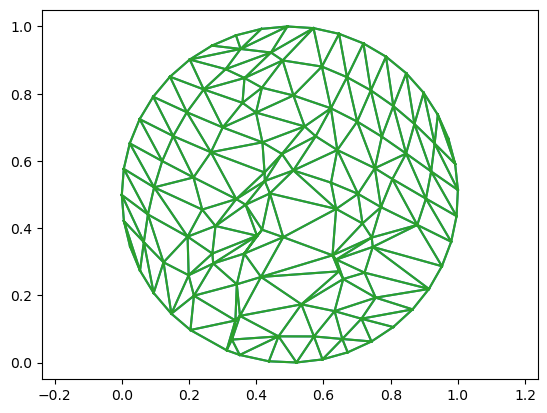

In [110]:
plt.triplot(*mesh_a.texture_vertices.T, mesh_a.texture_tris)

plt.triplot(*mesh_b.texture_vertices.T, mesh_b.texture_tris)
plt.axis("equal")

### Mesh registration

TO DO: use barycentric interpolation to copy over coordinates, remove `skfmm`-dependence

In [21]:
#| export

def extrapolate_fast_marching(arr):
    """Fill nans in 2d numpy array via fast-marching extrapolation."""
    mask = ~ndimage.binary_erosion(~np.isnan(arr), iterations=2)
    extended = skfmm.extension_velocities(mask, arr)[1]
    return extended

In [22]:
#| export

def wrap_coords_via_disk(mesh_source, mesh_target, n_grid=512):
    """
    Map 3d coords of source mesh to target mesh via a disk parametrization. 
    
    """
    # compute harmonic map to disk
    mesh_source_disk = map_to_disk(mesh_source)
    mesh_target_disk = map_to_disk(mesh_target)
    # rotational alignment of parametrizations
    mesh_source_disk.texture_vertices = rotational_align_disk(mesh_source_disk, mesh_target_disk)
    # interpolate 3d coordinates. we use a grid and extend the interpolated UV coordinates
    # to the whole UV square in order to avoid issues with the disk boundary.
    U, V = np.meshgrid(*2*[np.linspace(0, 1, n_grid)])
    triangulation_target = mpl.tri.Triangulation(*mesh_target_disk.texture_vertices.T,
                                                 mesh_target_disk.texture_tris)
    interpolators = [mpl.tri.LinearTriInterpolator(triangulation_target, x) for x in mesh_target_disk.vertices.T]
    interpolated = np.stack([extrapolate_fast_marching(np.array(f(U, V))) for f in interpolators], axis=0)
    # interpolate onto source mesh
    new_coords = np.stack([interpolate.interpn((U[0], V[:,0]), x, mesh_source_disk.texture_vertices[:,::-1])
                           for x in interpolated], axis=-1)
    return new_coords

In [23]:
#| export

def wrap_coords_via_disk_no_skfmm(mesh_source, mesh_target):
    """
    Map 3d coords of source mesh to target mesh via a disk parametrization. 
    
    """
    # compute harmonic map to disk
    mesh_source_disk = map_to_disk(mesh_source)
    mesh_target_disk = map_to_disk(mesh_target)
    # rotational alignment of parametrizations
    mesh_source_disk.texture_vertices = rotational_align_disk(mesh_source_disk, mesh_target_disk)
    # interpolate 3d coordinates
    triangulation_target = mpl.tri.Triangulation(*mesh_target_disk.texture_vertices.T,
                                                 mesh_target_disk.texture_tris)
    interpolators = [mpl.tri.LinearTriInterpolator(triangulation_target, z) for z in mesh_target_disk.vertices.T]
    interpolated = np.stack([np.array(f(*mesh_source_disk.texture_vertices.T)) for f in interpolators], axis=-1)
    # fix issues due to the boundary - there may be texture vertices of the source mesh
    # we first fix all the boundary vertices which are nan by interpolating from the two closest target boundary pts
    bnd_source = igl.boundary_loop(mesh_source_disk.texture_tris)
    bnd_target = igl.boundary_loop(mesh_target_disk.texture_tris)
    tree = spatial.cKDTree(mesh_target_disk.texture_vertices[bnd_target])
    dists, inds = tree.query(mesh_source_disk.texture_vertices[bnd_source], k=2)
    dists = (dists.T / dists.sum(axis=1)).T
    interpolated_bdry = (mesh_target_disk.vertices[bnd_target][inds].T * dists.T).sum(axis=1).T
    nan_and_bdry = np.isnan(interpolated[bnd_source]).any(axis=1)
    interpolated_bdry[~nan_and_bdry] = interpolated[bnd_source][~nan_and_bdry]
    interpolated[bnd_source] = interpolated_bdry
    # now there still may be interior vertices which are nan. we fix them via a second round of interpolation
    if np.isnan(interpolated).any():
        mask = ~np.isnan(interpolated).any(axis=-1)
        missing = np.stack([interpolate.LinearNDInterpolator(mesh_source_disk.texture_vertices[mask], x[mask])(
            mesh_source_disk.texture_vertices[~mask]) for x in interpolated.T], axis=-1)
        interpolated[~mask] = missing
    return interpolated

In [24]:
mesh_source = tcio.ObjMesh.read_obj("movie_example/plane_example.obj")
mesh_target = deepcopy(mesh_source)

random_rot = stats.special_ortho_group.rvs(3)
mesh_target.vertices = mesh_target.vertices@random_rot + np.array([2, 9, 1])

In [25]:
mesh_source = tcio.ObjMesh.read_obj("movie_example/plane_example.obj")
mesh_target = deepcopy(mesh_source)

random_rot = stats.special_ortho_group.rvs(3)
mesh_target.vertices = mesh_target.vertices@random_rot + np.array([2, 9, 1])

In [26]:
new_coords = wrap_coords_via_disk(mesh_source, mesh_target)

In [27]:
np.linalg.norm(new_coords-mesh_target.vertices, axis=-1).mean()

0.00691645255009218

In [28]:
np.linalg.norm(mesh_source.vertices-mesh_target.vertices, axis=-1).mean()

9.361719071451468

In [29]:
new_coords_no_skfmm = wrap_coords_via_disk_no_skfmm(mesh_source, mesh_target)

In [30]:
np.linalg.norm(new_coords_no_skfmm-mesh_target.vertices, axis=-1).mean()

0.03481346768992773

## Sphere

For the sphere, we follow https://www.cs.cmu.edu/~kmcrane/Projects/MobiusRegistration/paper.pdf. Basically, the Riemann mapping theorem guarantees there is a conformal map of our surface to the unit sphere. This map is unique up to Moebius transformations (inversion about a point in the unit ball, and rotations). We fix the inversions by chosing the conformal map with the least amount of area distortion, and the rotation by registering the conformal factors as functions on the unit sphere using spherical harmonics

- Cut sphere to disk by removing a single vertex
- Map disk to plane conformally using least-squares conformal map
- Map disk to sphere using stereographic projection, with initially removed vertex at 
- Fix Moebius inversion by chosing conformal map with minimal distortion using Algorithm 1 from https://www.cs.cmu.edu/~kmcrane/Projects/MobiusRegistration/paper.pdf
- Rotational registration using spherical harmonics (in progress)

In [31]:
mesh = deepcopy(mesh_final_UV)

In [32]:
## Let's test this before computing the full map

# remove "north pole" - by convention, the last vertex in the mesh
north_pole = mesh.vertices.shape[0]-1
tri_mask = (mesh.tris==north_pole).any(axis=1) 
faces_disk = mesh.tris[~tri_mask]
vertices_disk = mesh.vertices[:-1]
## Find the open boundary
bnd = igl.boundary_loop(faces_disk)
## least squares conformal map
bnd = igl.boundary_loop(faces_disk)

b = np.array([bnd[0], bnd[int(np.round(len(bnd)/2))]])
bc = np.array([[0.0, -1.0], [0.0, 1.0]])

# LSCM parametrization
_, uv = igl.lscm(vertices_disk, faces_disk, b, bc)
uv = uv-uv.mean(axis=0)

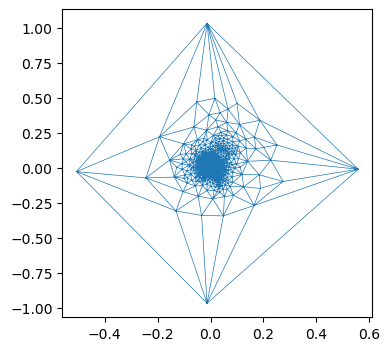

In [33]:
fig = plt.figure(figsize=(4,4))

plt.triplot(*uv.T, faces_disk, lw=0.5)

In [34]:
#| export

def stereographic_plane_to_sphere(uv):
    """
    Stererographic projection from plane to unit sphere from north pole (0,0,1).
    
    See https://en.wikipedia.org/wiki/Stereographic_projection.
    Convention: plane is at z=0, unit sphere centered at origin.
    uv should be an array of shape (..., 2)
    """
    return (np.stack([2*uv[:,0], 2*uv[:,1], uv[:,0]**2+uv[:,1]**2-1], axis=0) / (1+uv[:,0]**2+uv[:,1]**2)).T
    
def stereographic_sphere_to_plane(pts):
    """
    Stererographic projection from unit sphere to plane from north pole (0,0,1).
    
    See https://en.wikipedia.org/wiki/Stereographic_projection.
    Convention: plane is at z=0, unit sphere centered at origin.
    pts should be an array of shape (..., 3)
    """
    assert np.allclose(np.linalg.norm(pts, axis=1), 1, rtol=1e-03, atol=1e-04), "Points not on unit sphere!"
    return (np.stack([pts[:,0], pts[:,1]], axis=0)/(1-pts[:,2])).T

In [35]:
np.allclose(np.linalg.norm(stereographic_plane_to_sphere(uv), axis=1), 1)

True

In [36]:
np.allclose(stereographic_sphere_to_plane(stereographic_plane_to_sphere(uv)), uv)

True

### Moebius centering algorithm

Algorithm 1 from https://www.cs.cmu.edu/~kmcrane/Projects/MobiusRegistration/paper.pdf

In [37]:
#| export

def center_moebius(vertices_3d, vertices_sphere, tris, n_iter_centering=10, alpha=0.5):
    """
    Apply Moeboius inversions to minimize area distortion of map from mesh to sphere.
    
    Implementation of Algorithm 1 from:
    https://www.cs.cmu.edu/~kmcrane/Projects/MobiusRegistration/paper.pdf
    
    Parameters
    ----------
    vertices_3d : np.array of shape (n_verts, 3)
        3d mesh vertices
    vertices_sphere : np.array of shape (n_verts, 3)
        Initial vertex positions on unit shpere
    tris : np.array of shape (n_faces, 3) and dtype int
        Faces of triangular mesh
    n_iter_centering : int
        Centering algorithm iterations.
    alpha : float between 0 and 1
        Learning rate. Lower values make the algorithm more stable
    
    Returns
    -------
    vertices_sphere_centered : np.array of shape (n_verts, 3)
        Centered sphere coordinates
    com_norm : float
        Distance of sphere vertex center of mass from origin. Low values
        indicate convergence of algorithm.
    """
    As = igl.doublearea(vertices_3d, tris)
    As /= As.sum()
    Vs = np.copy(vertices_sphere)
    for i in range(n_iter_centering):
        # compute triangle centroids
        Cs = Vs[tris].mean(axis=1)
        Cs = (Cs.T/np.linalg.norm(Cs,axis=-1)).T
        # compute center of mass, weighted by 3d areas
        mu = (As*Cs.T).sum(axis=1)
        # compute Jacobian and get inversion center
        J = (As*(np.eye(3) - np.einsum('vi,vj->vij', Cs, Cs)).T).sum(axis=-1)
        c = -alpha*np.linalg.inv(J)@mu
        # compute inversion
        Vs = ((1-np.linalg.norm(c)**2)*(Vs+c).T /np.linalg.norm(Vs+c, axis=1)**2).T + c
    return Vs, np.linalg.norm(mu)

### Putting it all together

In [38]:
#| export

def map_to_sphere(mesh, n_iter_centering=10, alpha=0.5):
    """
    Compute conformal map of mesh to unit sphere.
    
    First, remove one vertex (last one by default), and map the resulting disk-topology
    mesh to the plane using least squares conformal maps. Then map the plane to
    the sphere using stereographic projection.
    
    The conformal map is chosen so that area distortion is as small as possible by
    (a) optimizing over the scale ("radius") of the map to the disk and (b) "centering"
    the map using Algorithm 1 from cs.cmu.edu/~kmcrane/Projects/MobiusRegistration/paper.pdf.
    
    This means the map is canonical up to rotations of the sphere.
    
    Parameters
    ----------
    mesh : tcio.ObjMesh
        Mesh. Must be topologically a sphere, and should be triangular.
    n_iter_centering : int
        Centering algorithm iterations. If 0, no centerting is performed
    alpha : float between 0 and 1
        Learning rate. Lower values make the centering algorithm more stable
    
    Returns
    -------
    vertices_sphere : np.array
        Sphere coordinates
    """
    if not mesh.is_triangular:
        warnings.warn("Warning: ignoring non-triangular faces", RuntimeWarning)
    # remove "north pole" - by convention, the last vertex in the mesh
    north_pole = mesh.vertices.shape[0]-1
    faces_all = mesh.tris
    tri_mask = (faces_all==north_pole).any(axis=1) 
    faces_disk = faces_all[~tri_mask]
    vertices_disk = mesh.vertices[:-1]
    ## Find the open boundary
    bnd = igl.boundary_loop(faces_disk)
    ## least squares conformal map
    bnd = igl.boundary_loop(faces_disk)
    b = np.array([bnd[0], bnd[int(np.round(len(bnd)/2))]])
    bc = np.array([[0.0, -1.0], [0.0, 1.0]])
    _, uv = igl.lscm(vertices_disk, faces_disk, b, bc)
    uv = uv-uv.mean(axis=0)
    # map plane to sphere. the scale factor of the map mesh -> plane is arbitrary,
    # so we chose it in a way that minimizes area distortion
    areas = igl.doublearea(mesh.vertices, faces_all)
    areas = (areas/areas.mean())
    def get_distoration(R):
        """
        Measure area distortion as function of mesh -> plane scale factor.
        """
        coords_sphere = np.vstack([stereographic_plane_to_sphere(R*uv), np.array([0,0,1])])
        areas_sphere = igl.doublearea(coords_sphere, faces_all)
        areas_sphere = (areas_sphere/areas_sphere.mean())
        distortion = np.log(areas_sphere/areas)
        return np.abs(distortion).mean()
    R_opt = optimize.minimize_scalar(get_distoration, bracket=(1e-2, 1e5)).x
    vertices_sphere = np.vstack([stereographic_plane_to_sphere(R_opt*uv), np.array([0,0,1])])
    # center map to sphere using Moebius ivnersions
    if n_iter_centering > 0:
        vertices_sphere, _ = center_moebius(mesh.vertices, vertices_sphere, faces_all,
                                            n_iter_centering=n_iter_centering, alpha=alpha)
    return vertices_sphere

In [39]:
mesh = deepcopy(mesh_final_UV)
coords_sphere = map_to_sphere(mesh)

In [40]:
tcio.ObjMesh(vertices=coords_sphere, faces=mesh.tris).write_obj("movie_example/map_to_sphere.obj")
# looks ok

### Check that the Moebius centering algorithm improves area distortion

In [41]:
# get the area distortion. did it go down?

vertices_sphere_uncentered = map_to_sphere(mesh, n_iter_centering=0)

In [42]:
coords_sphere_centered, error = center_moebius(mesh.vertices, vertices_sphere_uncentered,
                                               mesh.tris, n_iter_centering=10, alpha=0.5)

In [43]:
error

2.3689993928300783e-17

In [44]:
areas_3d = igl.doublearea(mesh.vertices, mesh.tris)

areas_sphere = igl.doublearea(vertices_sphere_uncentered, mesh.tris)
distortion = np.log(areas_sphere/areas_3d)
distortion -= distortion.mean()

areas_sphere_centered = igl.doublearea(coords_sphere_centered, mesh.tris)
distortion_centered = np.log(areas_sphere_centered/areas_3d)
distortion_centered -= distortion_centered.mean()

In [45]:
np.abs(distortion).mean(), np.abs(distortion_centered).mean()

(1.8236377265712769, 1.2906597362033387)

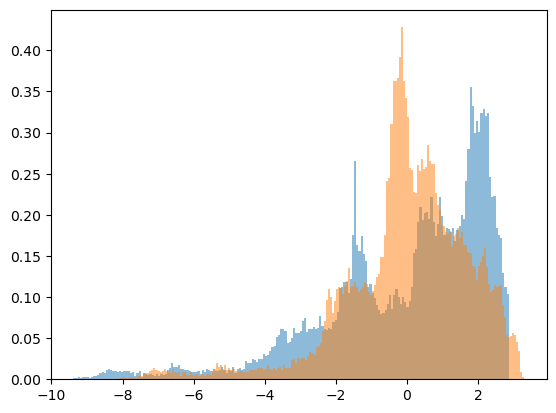

In [46]:
plt.hist(distortion, density=True, bins=200, alpha=0.5);
plt.hist(distortion_centered, density=True, bins=200, alpha=0.5);

### Rotation alignment using `rotation` module

In [47]:
rot_mat = stats.special_ortho_group.rvs(3)
rot_mat

array([[-0.51755702,  0.63302083,  0.57569033],
       [-0.66292582,  0.12873152, -0.73753478],
       [-0.54098437, -0.76335629,  0.35301995]])

In [ ]:
coords_sphere = map_to_sphere(mesh)

In [1097]:
%%time

q_opt, overlap = rotation_alignment_brute_force(spherical_harmonics_coeffs_direct,
                                                spherical_harmonics_coeffs_rotated,
                                                max_l=10, n_angle=100, n_subdiv_axes=1)
q_opt, overlap

CPU times: user 1.43 s, sys: 3.88 ms, total: 1.43 s
Wall time: 1.43 s


(array([ 0.27899111,  0.65147037,  0.26088191, -0.65550816]),
 (0.9754229834851306+7.47894889240496e-16j))

In [1098]:
rot_mat_to_quaternion(rot_mat)

array([ 0.22501326,  0.54589581,  0.29434845, -0.75148239])

In [1108]:
%%time
rotation_alignment_refined(spherical_harmonics_coeffs_direct, spherical_harmonics_coeffs_rotated, q_opt,
                           max_l=10, maxfev=200)

CPU times: user 1.2 s, sys: 3.9 ms, total: 1.21 s
Wall time: 1.2 s


(array([ 0.22501253,  0.54589422,  0.29434849, -0.75148375]),
 -0.9959738454051245,
 -0.9726434859693891)

In [1106]:
#| export

def _get_minus_overlap(q, sph_harmonics_source, sph_harmonics_target, max_l=None, binomial_matrix=None,):
    """
    Get negative overlap between spherical harmonics, as function of rotation q, for optimization.
    """
    if max_l is None:
        max_l = min([max(sph_harmonics_source.keys()), max(sph_harmonics_target.keys())])    
    corr_coeff = 0
    for l in range(0, max_l):
        D_matrix = get_wigner_D_matrix(q/np.linalg.norm(q),
                                       l=l, binomial_matrix=binomial_matrix)
        corr_coeff += np.sum(D_matrix@spherical_harmonics_coeffs_direct[l]
                             *np.conjugate(spherical_harmonics_coeffs_rotated[l]))
    normalization = np.sqrt(np.abs(np.sum([val.dot(np.conjugate(val)) for val in sph_harmonics_source.values()])
                                  *np.sum([val.dot(np.conjugate(val)) for val in sph_harmonics_target.values()])))
    return -np.abs(corr_coeff)/normalization

def rotation_alignment_refined(sph_harmonics_source, sph_harmonics_target, q_initial,
                               max_l=None, maxfev=200):
    """
    Refine rotational alignment between two signals on sphere by optimization.
    
    The two signals have to be represented by their spherical harmonics coefficients.
    Uses Wigner-D matrices to calculate the overlap between the two signals
    and uses Nelder-Mead optimization to find the best one.
    
    Requires a good initial guess for the rotation, as created by 
    rotation_alignment_brute_force.
    
    The rotation is such that it transforms the source signal to match the target.
        
    Parameters
    ----------
    sph_harmonics_source : dict of np.array
        Dictionary, indexed by total angular momentum l=0 ,..., max_l. Each entry is a vector
        of coefficients for the different values of m=-2l,...,2*l. Source signal, to be
        transformed.
    sph_harmonics_target : dict of np.array
        Dictionary, indexed by total angular momentum l=0 ,..., max_l. Each entry is a vector
        of coefficients for the different values of m=-2l,...,2*l. Target signal.
    q_initial : 4d np.array
        Initial rotation as quaternion
    max_l : int
        Maximum angular momentum. If None, the maximum value available in the input
        spherical harmonics is used.
    maxfev : int
        Number of function evaluations during optimization.This parameter has
        the strongest influence on the run time.
    
    Returns
    -------
    optimal_rotation : 4d np.array
        Best rotation as unit quaternion.
    overlap : float
        Normalized overlap. 1=perfect alignment.
    overlap_initial : float
        Normalized overlap of initial condition. 1=perfect alignment. 
    """
    if max_l is None:
        max_l = min([max(sph_harmonics_source.keys()), max(sph_harmonics_target.keys())])
    args = (sph_harmonics_source, sph_harmonics_target, max_l, get_binomial_matrix(2*max_l))
    sol = optimize.minimize(_get_minus_overlap, q_initial, args=args, method="Nelder-Mead", tol=1e-5,
                            options={"maxfev": maxfev})
    return sol.x/np.linalg.norm(sol.x), sol.fun, get_minus_overlap(q_opt, *args)



### Interpolation

Now that we have (a) mapped both meshes to the sphere, (b) minized distortion via Moebius centering, (c) rotationally aligned the two maps via spherical harmonics, we can interpolate the coordinates of mesh B onto mesh A.

In [167]:
# first - find closest point and triangles 
igl.point_mesh_squared_distance

<function igl.pyigl.PyCapsule.point_mesh_squared_distance>

In [168]:
mesh_source = deepcopy(mesh_final_UV)
coords_sphere_source = map_to_sphere(mesh_source)

mesh_target = deepcopy(mesh_initial_UV)
coords_sphere_target = map_to_sphere(mesh_target)

# to do: rotational alignment

In [178]:
# find closest points and triangles on target mesh
distances, indices, points = igl.point_mesh_squared_distance(coords_sphere_source, coords_sphere_target,
                                                             mesh_target.tris)
hit_tris = mesh_target.tris[indices]
# barycentric coordinates of the hit points. need small hack for data type issue 
igl.barycentric_coordinates_tri(np.array(points, order="C"),
                                *np.array(coords_sphere_target[hit_tris].transpose((1,0,2)), order='C'))
# using the barycentric coords we can now interpolate

array([[0.26281583, 0.01812968, 0.71905448],
       [0.06225799, 0.20963935, 0.72810265],
       [0.03082458, 0.23923356, 0.72994186],
       ...,
       [0.70485954, 0.25354762, 0.04159284],
       [0.26122092, 0.3340902 , 0.40468889],
       [0.1827702 , 0.26508287, 0.55214693]])

In [175]:
igl.barycentric_coordinates_tri(np.array(points, order="C"),
                                *np.array(coords_sphere_target[hit_tris].transpose((1,0,2)), order='C'))


array([[0.26281583, 0.01812968, 0.71905448],
       [0.06225799, 0.20963935, 0.72810265],
       [0.03082458, 0.23923356, 0.72994186],
       ...,
       [0.70485954, 0.25354762, 0.04159284],
       [0.26122092, 0.3340902 , 0.40468889],
       [0.1827702 , 0.26508287, 0.55214693]])

In [ ]:
coords_sphere_source.

In [ ]:
## make that a more general function!

array([[ 7439,  7441,  7444],
       [ 7443,  7439,  7444],
       [ 7443,  7439,  7444],
       ...,
       [18167, 18166, 18164],
       [10186,  1009,  1014],
       [19419, 19422, 19421]])

In [125]:
hit_tris

array([[ 7439,  7441,  7444],
       [ 7443,  7439,  7444],
       [ 7443,  7439,  7444],
       ...,
       [18167, 18166, 18164],
       [10186,  1009,  1014],
       [19419, 19422, 19421]])

In [75]:
hit_tris

(22098, 3)

In [106]:
igl.barycentric_coordinates_tri(points,
                                np.array(coords_sphere_target[hit_tris[:,0]], order='F'),
                                np.array(coords_sphere_target[hit_tris[:,1]], order='F'),
                                np.array(coords_sphere_target[hit_tris[:,2]], order='F'))

array([[0.26281583, 0.01812968, 0.71905448],
       [0.06225799, 0.20963935, 0.72810265],
       [0.03082458, 0.23923356, 0.72994186],
       ...,
       [0.70485954, 0.25354762, 0.04159284],
       [0.26122092, 0.3340902 , 0.40468889],
       [0.1827702 , 0.26508287, 0.55214693]])

array([[0.26281583, 0.01812968, 0.71905448],
       [0.06225799, 0.20963935, 0.72810265],
       [0.03082458, 0.23923356, 0.72994186],
       ...,
       [0.70485954, 0.25354762, 0.04159284],
       [0.26122092, 0.3340902 , 0.40468889],
       [0.1827702 , 0.26508287, 0.55214693]])

In [105]:
igl.barycentric_coordinates_tri(points, 
                                *np.array(coords_sphere_target[hit_tris], order='F').transpose((1,0,2)))

ValueError: Invalid type (double, No Major) for argument 'a'. Expected it to match argument 'p' which is of type (double, Col Major).

In [104]:
 np.array(coords_sphere_target[hit_tris[:,:2]], order='F').transpose((1,0,2))

array([[[-0.51909001, -0.60778621, -0.60095049],
        [-0.52140105, -0.62042577, -0.58584368],
        [-0.52140105, -0.62042577, -0.58584368],
        ...,
        [ 0.11134281,  0.22433983,  0.96812934],
        [ 0.19733884,  0.77939728,  0.59464044],
        [ 0.29520136,  0.52213713,  0.8001431 ]],

       [[-0.52249527, -0.59090637, -0.61467744],
        [-0.51909001, -0.60778621, -0.60095049],
        [-0.51909001, -0.60778621, -0.60095049],
        ...,
        [ 0.12359749,  0.21360501,  0.96906995],
        [ 0.20256079,  0.77408932,  0.59979568],
        [ 0.29199672,  0.50454707,  0.81250857]]])

In [99]:
igl.barycentric_coordinates_tri(points[:],
                                points[:],
                                points[:],
                                np.array(coords_sphere_target[hit_tris[:,0]], order='F'))

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

array([[-0.51909001, -0.60778621, -0.60095049],
       [-0.52140105, -0.62042577, -0.58584368],
       [-0.52140105, -0.62042577, -0.58584368],
       ...,
       [ 0.11134281,  0.22433983,  0.96812934],
       [ 0.19733884,  0.77939728,  0.59464044],
       [ 0.29520136,  0.52213713,  0.8001431 ]])

In [89]:
points[:].shape

(22098, 3)

In [79]:
points[0]

(3,)

In [82]:
coords_sphere_target[hit_tris[0,0]].shape

(3,)

In [72]:
help(igl.barycentric_coordinates_tri)

Help on built-in function barycentric_coordinates_tri in module igl.pyigl:

barycentric_coordinates_tri(...) method of builtins.PyCapsule instance
    barycentric_coordinates_tri(p: numpy.ndarray, a: numpy.ndarray, b: numpy.ndarray, c: numpy.ndarray) -> object
    
    
    
    Compute barycentric coordinates in a triangle corresponding to the Euclidean coordinates in `p`.
    The input arrays `a`, `b`, and `c` are the vertices of each triangle. I.e. one triangle is
    `a[i, :], b[i, :], c[i, :]`.
    
    Parameters
    ----------
    p : #P by 3 Query points in 3d
    a : #P by 3 Tri corners in 3d
    b : #P by 3 Tri corners in 3d
    c : #P by 3 Tri corners in 3d
    
    Returns
    -------
    #P by 3 list of barycentric coordinates
    
    See also
    --------
    
    Notes
    -----
    
    Examples
    --------



## Stuff that did not work out well

### Thin-plate spline registration

Decided not to bother.

### Non-rigid ICP

Try it out first using trimesh, then do myself to avoid dependency. Use `trimesh.registration.nricp_sumner`


-> No good, takes forever and my laptop runs out of memory. Also lots of parameters to tune whose meaning I don't know.

### Laplace Beltrami based

Idea - compute the eigenfunctions $\phi_i$ of the Laplace operator $\Delta$ on the surface, and the embed each point $p$ on the surface as $p\mapsto \phi_i(p)/\sqrt{\lambda_i}$. 

Works "ok" - in the sense that eigenfunctions 1-3 give a non-degenerate looking surface in 3d - for initial gut which looks not so different from a sphere. Late gut becomes extremely elongated / thin in spectral embedding. 

Not suitable.

See https://www.cs.jhu.edu/~misha/ReadingSeminar/Papers/Rustamov07.pdf, https://web.archive.org/web/20100626223753id_/http://www.cs.jhu.edu/~misha/Fall07/Notes/Rustamov07.pdf

In [7]:
mesh = mesh_initial_UV
laplacian = igl.cotmatrix(mesh.vertices, mesh.tris)
mass = igl.massmatrix(mesh.vertices, mesh.tris)

In [8]:
%%time
#eigen_vals, eigen_vecs = sparse.linalg.eigsh(-laplacian, k=20, ncv=100, which="SM")
eigen_vals, eigen_vecs = sparse.linalg.eigsh(-laplacian, M=mass, k=10, ncv=100, which="SM")

eigen_vals, eigen_vecs = (eigen_vals[1:], eigen_vecs[:, 1:])

CPU times: user 14.1 s, sys: 1.92 s, total: 16 s
Wall time: 4.73 s


In [9]:
eigen_vals = eigen_vals / eigen_vals[0]
eigen_vecs = eigen_vecs / np.abs(eigen_vecs).mean()

In [10]:
eigen_vals

array([1.        , 2.65519815, 2.88771164, 3.3817486 , 5.14938654,
       5.48724185, 6.51192566, 8.5687819 , 9.36389656])

In [13]:
matched_vertex_inds = mesh.get_uv_matched_vertex_indices()

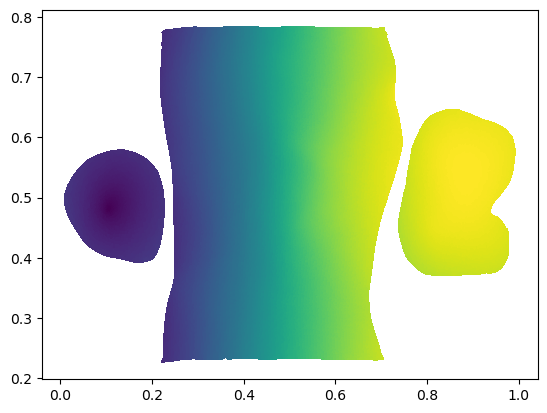

In [14]:
plt.tripcolor(*mesh.texture_vertices.T, mesh.texture_tris, eigen_vecs[matched_vertex_inds,0])

In [157]:
mesh_spectral = deepcopy(mesh)
mesh_spectral.vertices = eigen_vecs[:,:3] *np.array([11,1,1]) / np.sqrt(eigen_vals[:3])
mesh_spectral.write_obj("movie_example/spectral_final.obj")

### Functional mapping

https://people.csail.mit.edu/jsolomon/assets/fmaps.pdf - uses Laplace Beltrami descriptors. There appears to be an existing implementation in python: https://github.com/RobinMagnet/pyFM. Let's try out https://github.com/RobinMagnet/pyFM/blob/master/examples/mesh_and_matching/basic_functions.ipynb

It does not work that well. Ok for matching from mapping timepoints 1->2, bad for 1->20, or 20->30. I get "patchy correspondences": the map mesh A -> mesh B is not continous and tears up mesh A into multiple patches that are stitched together in somewhat random order on mesh B.  Also kinda slow.

As Dillon pointed out, shape descriptors of Laplace-Beltrami kind fundamentally use _metric_ information. Laplace Beltramis is equivalent to a metric. Good for isometric deformations, like joint movements, bad for non-isometric, which is standard for us.

So in principle this is a nice method, but not quite what we need.

There's also "soft shells" but that code requires pytorch etc and is not really documented: https://github.com/marvin-eisenberger/deep-shells/

In [85]:
# add tutorial option meshplot

In [1]:
from pyFM.mesh import TriMesh
from pyFM.functional import FunctionalMapping

In [2]:
import meshplot as mp

In [3]:
def plot_mesh(myMesh,cmap=None):
    mp.plot(myMesh.vertlist, myMesh.facelist,c=cmap)
    
def double_plot(myMesh1,myMesh2,cmap1=None,cmap2=None):
    d = mp.subplot(myMesh1.vertlist, myMesh1.facelist, c=cmap1, s=[2, 2, 0])
    mp.subplot(myMesh2.vertlist, myMesh2.facelist, c=cmap2, s=[2, 2, 1], data=d)

def visu(vertices):
    min_coord,max_coord = np.min(vertices,axis=0,keepdims=True),np.max(vertices,axis=0,keepdims=True)
    cmap = (vertices-min_coord)/(max_coord-min_coord)
    return cmap

In [ ]:
meshes_dict = {i: tcio.read_other_formats_without_uv(f"movie_example/meshes/mesh_{str(i).zfill(2)}.ply")
               for i in tqdm(range(1, 32))}

In [14]:
mesh1 = TriMesh(meshes_dict[1].vertices, meshes_dict[1].tris)
mesh2 = TriMesh(meshes_dict[5].vertices, meshes_dict[5].tris)

In [16]:
# distance computation using heat geodesic  -replace potpourri backend by igl.heat_geodesic
# or igl.exact_geodesic
dists = mesh1.geod_from(1000, robust=True)

In [17]:
mesh1.process(k=100, intrinsic=True, verbose=True);

Computing 100 eigenvectors
	Done in 5.30 s


In [18]:
mesh2.process(k=100, intrinsic=True, verbose=True);

Computing 100 eigenvectors
	Done in 5.20 s


#### Compute the functional map

In [76]:
# load data

t0 = 20
t1 = 30

mesh1 = TriMesh(meshes_dict[t0].vertices, meshes_dict[t0].tris)
mesh2 = TriMesh(meshes_dict[t1].vertices, meshes_dict[t1].tris)

In [77]:
# compute descriptors

process_params = {
    'n_ev': (35,35),  # Number of eigenvalues on source and Target. - also no improvement
    'subsample_step': 5,  # In order not to use too many descriptors. makes no big difference
    'descr_type': 'WKS',  # WKS or HKS - makes no big difference
}

model = FunctionalMapping(mesh1, mesh2)
model.preprocess(**process_params,verbose=True);


Computing Laplacian spectrum
Computing 200 eigenvectors
	Done in 12.41 s
Computing 200 eigenvectors
	Done in 27.69 s

Computing descriptors
	Normalizing descriptors

	20 out of 100 possible descriptors kept


#### Fitting the transformation model

In [78]:
fit_params = {
    'w_descr': 1e0,
    'w_lap': 1e-2,
    'w_dcomm': 1e-1,
    'w_orient': 1e-2}


model.fit(**fit_params, verbose=True)

Computing commutativity operators
Computing orientation operators
	Scaling LBO commutativity weight by 3.9e+04
	Scaling orientation preservation weight by 1.2e+14

Optimization :
	35 Ev on source - 35 Ev on Target
	Using 20 Descriptors
	Hyperparameters :
		Descriptors preservation :1.0e+00
		Descriptors commutativity :1.0e-01
		Laplacian commutativity :1.0e-02
		Orientation preservation :1.2e+12

	Task : CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL, funcall : 173, nit : 162, warnflag : 0
	Done in 0.34 seconds


In [79]:
# we can already see that this has errors - bad patches if map is over larger distances
# like from tpt 1 -> 20. need w_orient >0 . Do I need more descriptors? HKS or WKS?

In [80]:
p2p_21 = model.get_p2p(n_jobs=1)
cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21]
double_plot(mesh1,mesh2,cmap1,cmap2)

#### Refining

This does improve things.

In [81]:
model.icp_refine(verbose=True)
p2p_21_icp = model.get_p2p()


  0%|          | 0/10 [00:00<?, ?it/s]

In [82]:
cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21_icp]
double_plot(mesh1,mesh2,cmap1,cmap2)

In [83]:
model.change_FM_type('classic') # We refine the first computed map, not the icp-refined one
model.zoomout_refine(nit=15, step = 1, verbose=True)
print(model.FM.shape)
p2p_21_zo = model.get_p2p()

  0%|          | 0/15 [00:00<?, ?it/s]

(50, 50)


In [84]:
cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21_zo]
double_plot(mesh1,mesh2,cmap1,cmap2)